In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from __future__ import division

PATH = '../data/data/'

%matplotlib inline

## Predict short term movements in stock prices using news and sentiment data provided by RavenPack



** We have to develop a model that predicts stock price movements using sentiment data provided by RavenPack. Traders, analysts and investors are always looking for techniques to better predict price movements.  Knowing whether a security will increase or decrease allows traders to make better investment decisions and manage risk more effectively.**

** Objective **

<p>We have to predict the percentage change in a financial instrument at a time 2 hours in the future.  The data represents features of various financial securities (198 in total) recorded at 5-minute intervals throughout a trading day. Features' names or the specific dates are not provided.</p>

* Each variable named O1, O2, O3, etc. (the outputs) represents a percent change in the value of a security.  

* Each variable named I1, I2, I3, etc. (the inputs) represents a feature. The underlying securities and features represented by these anonymized names are the same across all files (e.g. O1 will always be the same stock).

* We are provided the outputs as a relative percentage compared to the previous day's closing price.  The first line of each data file represents the previous close. For example, if a security closed at 1dollar the previous day and opened at 2 dollar the next day, the first output would be 0, then 100.  All output values are computed relative to the previous day's close. The timestamps within each file are as follows (ignoring the header row):

* Line 1 = Outputs and inputs at previous day's close (4PM ET)
* Line 2 = Outputs and inputs at current day's open (9:30AM ET)
* Line 3 = Outputs and inputs at 9:35AM ET
* ...
* Line 55 = Outputs and inputs at 1:55PM ET

> We have to predict the outputs 2 hours later, at 4PM ET.

## Evaluation

Submissions are evaluated by the mean absolute error between the predicted percentage change and the actual percentage change.

$$MAE=\frac{1}{n}\sum_{i=1}^{n}\left|{y_i−ŷ_i}\right|$$


In [11]:
# load in all the dataset
files = glob(os.path.join(PATH, '*.csv'))

data_df = pd.concat((pd.read_csv(f) for f in files))

In [17]:
# load target labels
target = pd.read_csv('../data/trainLabels.csv', index_col='FileId'); target.head()

,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,...,O189,O190,O191,O192,O193,O194,O195,O196,O197,O198
FileId,,,,,,,,,,,,,,,,,,,,,
1,2.53,1.03,0.12,0.01,0.07,0.88,1.30,1.82,2.13,1.34,...,-0.65,1.58,1.75,-0.10,0.04,0.60,2.04,3.69,3.56,2.03
2,-4.95,0.18,-0.24,-0.04,-0.49,0.68,0.80,0.64,0.92,0.58,...,0.14,0.64,0.47,0.56,0.47,1.34,1.06,1.22,-0.04,0.38
3,0.16,0.00,0.20,-0.20,-0.11,0.76,0.88,0.18,0.45,0.26,...,0.33,0.84,1.22,0.25,1.50,0.70,1.79,-0.04,1.30,1.61
4,4.43,0.06,-0.20,-0.45,-0.62,0.13,4.35,1.47,0.36,2.65,...,-0.27,-0.49,-0.99,0.75,0.30,0.47,-0.02,-0.79,-0.43,-0.53
5,0.76,0.11,0.12,0.08,-0.25,0.12,-0.44,0.60,0.11,0.10,...,0.20,0.48,0.24,-0.11,0.08,0.40,-0.51,1.85,-0.53,-0.57


In [18]:
# first 200 days are training examples and rest 310 days should be used for training
# 200 * 55 = 11,000 examples will be included in training examples and rest would go in the test set

train = data_df.iloc[:11000]
test = data_df.iloc[11000:]

In [21]:
assert train.shape[0] == 11000
assert test.shape[0] == 17050

In [22]:
train.head()

,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,...,I235,I236,I237,I238,I239,I240,I241,I242,I243,I244
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.268207,0.523644,0.135028,0.226693,0.101070,0.094971,0.050332,0.299584,0.038816,0.081309
1,0.97,0.45,0.16,-0.04,0.21,0.29,0.61,0.79,0.90,-0.04,...,0.785809,1.033014,1.006048,1.132957,0.183963,0.144079,0.355715,0.314446,0.251952,0.206263
2,1.69,0.51,0.00,-0.04,0.31,0.30,0.67,0.81,0.96,0.18,...,0.745939,1.362954,0.945924,1.086542,0.366259,0.267723,0.630238,0.357783,0.510176,0.429069
3,1.71,0.64,0.00,-0.06,0.38,0.31,0.64,0.84,1.01,0.22,...,0.603695,1.209274,0.771079,0.880964,0.451086,0.333353,0.321455,0.388896,0.574862,0.511859
4,1.65,0.51,0.00,-0.06,0.41,0.25,0.58,0.81,0.99,0.18,...,0.466887,1.173604,0.706337,0.808645,0.514879,0.385068,0.050332,0.410417,0.569456,0.565194


## Approach : 1

** Take last observed 20 samples for each security on each day, take their mean and submit that value as the prediction after 2 hours **

** Error Metric is Mean Absolute Error **

In [43]:
def mae(y_true, y_pred):
    return (abs(y_true - y_pred)).mean(axis=1).mean()

In [52]:
def get_predictions(train, n=20):
    start_index = 0
    num_entries = 55
    preds = []
    
    for i in range(1, 201):
        end_index = i * num_entries
        day_activity  = train.iloc[start_index:end_index, 0:198]
        start_index = end_index
        
        pred_for_day = day_activity.iloc[n:].mean()
        preds.append(pred_for_day)
    
    return np.array(preds)

In [37]:
y_preds = get_predictions(train, 20)

In [48]:
def score_by_n(train, target):
    n_range = np.arange(1, 21)
    errors = []
    
    for n in n_range:
        preds = get_predictions(train, n)
        errors.append(mae(target, preds))
    
    return n_range, np.array(errors)

In [53]:
n_range, errors = score_by_n(train, target)

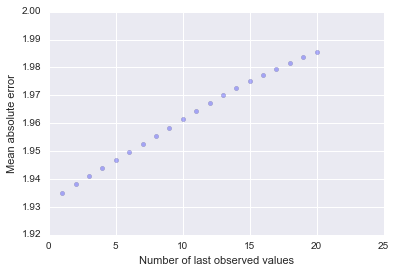

In [55]:
plt.scatter(n_range, errors, alpha=0.3)
plt.xlabel('Number of last observed values')
plt.ylabel('Mean absolute error');

## Approach: 2

A random walk is a mathematical formalization of a path that consists of a succession of random steps. For example, the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the price of a fluctuating stock and the financial status of a gambler can all be modeled as random walks, although they may not be truly random in reality.  ** Source: <a href="https://en.wikipedia.org/wiki/Random_walk">Wikipedia</a> **

In [99]:
def random_walk(train, n=20):
    start_index = 0
    num_entries = 55
    preds = []
    
    for i in range(1, 201):
        end_index = i * num_entries
        
        day_activity  = train.iloc[start_index:end_index, 0:198]
        start_index = end_index
        
        pred = np.zeros(day_activity.shape[1])
        
        current_index = 55 // 2
        
        for j in range(0, n):
            coin_flip = np.random.rand()
            
            if coin_flip < 0.5:
                current_index -= 1
                pred = pred + day_activity.iloc[current_index] 
            else:
                current_index += 1
                pred = pred + day_activity.iloc[current_index]
        
        pred = pred / n
        preds.append(pred)
    
    return np.array(preds)

In [100]:
y_preds = random_walk(train, 20)

In [102]:
def score_by_steps(train, target):
    n_range = np.arange(15, 31)
    errors = []
    
    for n in n_range:
        preds = random_walk(train, n)
        errors.append(mae(target, preds))
    
    return n_range, np.array(errors)

In [103]:
n_range, errors = score_by_steps(train, target)

In [ ]:
plt.scatter(n_range, errors)
plt.xlabel('Number of steps')
plt.ylabel('Mean Abso')